In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/

In [ ]:
import os
import zipfile
zip_ref=zipfile.ZipFile("/content/drive/MyDrive/FGNET.zip",'r')
zip_ref.extractall('/content/drive/MyDrive/FG_NET')
zip_ref.close()

In [ ]:
!ls "/content/drive/MyDrive/FG-NET/FGNET"

In [ ]:
import os
data_dir="/content/drive/MyDrive/FG-NET/FGNET/images"
files=os.listdir(data_dir)
print(len(files))

In [ ]:
# import os
# data_dir = 'FGNET/images'

# files = os.listdir(data_dir)

# print(len(files))

In [ ]:
import numpy as np
ages = []
for age in files:
  age = age[age.find('A') + 1: age.find('A') + 1 + 2]
  # print(age)
  ages.append(int(age))

ages = np.array(ages)

In [ ]:
len(ages)

# **Perform Data Exploration**

In [ ]:
import matplotlib.pyplot as plt

def _plot_bar(varname):
  labels, values = np.unique(ages, return_counts=True)
  plt.figure(figsize=(10, 6))
  ax = plt.subplot()
  ax.bar(x=labels, height=values)
  ax.set_title('No samples of ' + varname)
  ax.set_xlabel(varname)
  ax.set_ylabel('No samples')
  plt.show()

_plot_bar('ages')

In [ ]:
import pandas as pd

labels, values = np.unique(ages, return_counts=True)
age_df = pd.DataFrame(data = values, index = labels, columns = ['Freq'])

age_df

In [ ]:
age_df.describe()

In [ ]:



age_df.loc[age_df.idxmax()]

In [ ]:
age_df.loc[age_df.idxmin()]

In [ ]:
age_lst = list(age_df.index.values)

In [ ]:
#Find missing ages
miss_ages = []
for age in range(70):
  if age not in age_lst:
    miss_ages.append(age)

miss_ages

In [ ]:
import numpy as np
from PIL import Image
import progressbar

widgets = ['Reading images:',progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval = len(files), widgets = widgets).start()

images = []
for i, imageData in enumerate(files):
  image = np.array(Image.open(data_dir + '/' + imageData).convert('RGB').resize((224, 224)))
  images.append(image)
  pbar.update(i)

pbar.finish()

images = np.array(images)

In [ ]:
from matplotlib import image

plt.figure(figsize = (6, 6))
plt.imshow(images[10])
plt.show()

In [ ]:



print(ages[10])

In [ ]:
images[0].shape

In [ ]:
import matplotlib
def displayImage(startIdx, numImages, imagePath, showAge = True):
  endIdx = startIdx + numImages
  size = (5,5)
  fig = plt.figure(figsize = (3*numImages, 2*numImages))
  listImage = os.listdir(imagePath)
  for i, imagename in enumerate(listImage[startIdx : endIdx]):
    ax = fig.add_subplot(size[0], size[1], i + 1, xticks = [], yticks = [])
    img = matplotlib.image.imread(imagePath + '/' + imagename)
    ax.imshow(img)
    if showAge:
      ax.set_title('Imagename: {}, Age: {}'.format(imagename, ages[startIdx + i]), color = 'green')

In [ ]:
displayImage(20, 10, '/content/drive/MyDrive/FG-NET/FGNET/images')

**Split data in training set and validation set**

In [ ]:
from sklearn.model_selection import train_test_split

images = images.astype('float')/255

(trainData, testData, trainLabels, testLabels) = train_test_split(images, ages, test_size = 0.2, random_state = 42, shuffle =True)

**Create Dataset with tf.data.Dataset**

In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((trainData, trainLabels))
test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabels))

# **Perform Data Augmentation**

In [ ]:
def augment(image,label, mode):
  if mode == 'train':
    # image = tf.image.resize_with_crop_or_pad(image, 230, 230) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[218, 218, 3])
    image = tf.image.resize(image, size=[224, 224])
    image = tf.image.random_saturation(image, 2, 3)
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.image.random_flip_left_right(image)
    return image,label
  else:
    image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0, target_height=200, target_width=224)
    image_resized = tf.image.resize(image_cropped, size= [224,224])
    return image_resized, label

In [ ]:
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 16
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).map(lambda image, label: augment(image, label, mode = 'train'), num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE_TRAIN)
test_dataset = test_dataset.map(lambda image, label: augment(image, label, mode = 'eval'), num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE_TEST)

# **BUILDING MODEL BASE ON RESNET 34 ARCHITECTURE**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, BatchNormalization, ZeroPadding2D, Add, Input, AveragePooling2D, GlobalMaxPooling2D, Lambda
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf

In [ ]:
def identity_block(X, f, filters, stage, block):
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2 = filters

  X_shortcut = X

  X = Conv2D(filters = F1, kernel_size= (f,f), strides= (1,1), padding= 'same', name = conv_name_base + '2a', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F2, kernel_size= (f,f), strides= (1,1), padding= 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)

  X = Add()([X_shortcut, X])
  X = Activation('relu')(X)

  return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2 = filters

  X_shortcut = X

  X = Conv2D(filters = F1, kernel_size= (f,f), strides= (s,s), padding= 'same', name = conv_name_base + '2a', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F2, kernel_size= (f,f), strides= (1,1), padding= 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)

  X_shortcut = Conv2D(filters = F2, kernel_size=(1,1), strides = (s,s), name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed = 0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = -1, name = bn_name_base + '1')(X_shortcut)

  X = Add()([X_shortcut, X])
  X = Activation('relu')(X)

  return X

In [ ]:
def ResNet_34Base(input_shape, classes, activation = 'softmax'):
  X_input = Input(input_shape)

  X = ZeroPadding2D((3,3))(X_input)

  #Stage 1
  X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  #Stage 2
  X = convolutional_block(X, f = 3, filters = [64, 64], stage = 2, block = 'a', s = 1)
  X = identity_block(X, f = 3, filters= [64, 64], stage = 2, block = 'b')
  X = identity_block(X, f = 3, filters= [64, 64], stage = 2, block = 'c')

  #Stage 3
  X = convolutional_block(X, f = 3, filters = [128, 128], stage = 3, block = 'a', s = 2)
  X = identity_block(X, f = 3, filters= [128, 128], stage = 3, block = 'b')
  X = identity_block(X, f = 3, filters= [128, 128], stage = 3, block = 'c')
  X = identity_block(X, f = 3, filters= [128, 128], stage = 3, block = 'd')

  #Stage 4
  X = convolutional_block(X, f = 3, filters = [256, 256], stage = 4, block = 'a', s = 2)
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'b')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'c')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'd')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'e')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'f')

  #Stage 5
  X = convolutional_block(X, f = 3, filters = [512, 512], stage = 5, block = 'a', s = 2)
  X = identity_block(X, f = 3, filters= [512, 512], stage = 5, block = 'b')
  X = identity_block(X, f = 3, filters= [512, 512], stage = 5, block = 'c')

  X = AveragePooling2D(pool_size=(2,2), name = 'avg_pool')(X)

  X = Flatten()(X)
  X = Dense(classes, activation= 'softmax', name = 'fc' + str(classes), kernel_initializer=glorot_uniform(seed = 0))(X)

  model = Model(inputs = X_input, outputs = X, name = 'age_resnet_34')
  return model

In [ ]:
model = ResNet_34Base((224, 224, 3), 70)

In [ ]:
model.summary()

**Model Architecture**

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'Resnet34Base.png', show_shapes = True)

In [ ]:
def mean(p_i):
  mean = 0
  # print('y_pred_i', y_pred_i)
  # print('Shape', tf.shape(y_pred_i))
  # for j in range(tf.shape(y_pred_i).numpy().shape[1]):
  for j in range(len(p_i)):
    mean += p_i[j]*(j+1)
  return mean

In [ ]:
def variance(p_i):
  variance = 0
  # print('y_pred_i',y_pred_i)
  # for j in range(tf.shape(y_pred_i).numpy().shape[1]):
  for j in range(len(p_i)):
    variance += p_i[j]*((j+1) - mean(p_i))**2
  return variance

In [ ]:
def mean_loss(y_true, p_pred):
  # print('y_pred', y_pred)
  # print('y_true', y_true)
  # print('Shape', p_pred.numpy().shape)
  m_tensor = tf.constant([mean(i) for i in p_pred.numpy()], dtype = 'float32')
  squared_difference = tf.square(tf.cast(y_true, dtype = 'float32') - m_tensor)
  return (1/2)*tf.reduce_mean(squared_difference, axis=-1)

In [ ]:
def variance_loss(y_true, p_pred):
  total_variance = 0
  # for i in range(tf.shape(y_pred_i).numpy().shape[1]):
  # print(p_pred.numpy().shape)
  for i in range(p_pred.numpy().shape[0]):
    total_variance += variance(p_pred.numpy()[i])
  return (1/p_pred.numpy().shape[0])*total_variance

In [ ]:
def loss(model, x, y_true, lambda1, lambda2, training):
  p_pred = model(x, training=training)
  # y_pred = tf.constant([mean(i) for i in p_pred.numpy()], dtype = 'float32')
  # print(y_pred)
  softmax_Loss = tf.keras.losses.SparseCategoricalCrossentropy()
  return softmax_Loss(y_true, p_pred) + lambda1*mean_loss(y_true, p_pred) + lambda2*variance_loss(y_true, p_pred)

In [ ]:
INIT_LEARNING_RATE = 0.001
EPOCHS = 100
LAMBDA_1 = 0.2
LAMBDA_2 = 0.05

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LEARNING_RATE,
    decay_steps=200,
    decay_rate=0.1,
    staircase = True
)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

In [ ]:
def grad(model, inputs, targets, lambda1, lambda2):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, lambda1, lambda2, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
import progressbar

def train(train_set, test_set, model, h_para = {}):
  train_loss_results = []
  train_mae_results = []
  test_loss_results = []
  test_mae_results = []

  num_epochs, lambda1, lambda2 = h_para['epochs'], h_para['l_1'], h_para['l_2']

  # widgets = ['Epochs: ', progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
  # pbar = progressbar.ProgressBar(maxval = 1000, widgets = widgets).start()

  for epoch in range(num_epochs):
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_train_mae = tf.keras.metrics.MeanAbsoluteError()
    epoch_test_loss_avg = tf.keras.metrics.Mean()
    epoch_test_mae = tf.keras.metrics.MeanAbsoluteError()

    # Training loop - using batches of 64
    for count, (x, y) in enumerate(train_set):
      #Calculate loss value and update weight
      loss_value, grads = grad(model, x, y, lambda1, lambda2)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Track progress
      epoch_train_loss_avg.update_state(loss_value)  # Add current batch loss
      # Compare predicted label to actual label
      # training=True is needed only if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      probs = model(x, training=True)
      # y_hat = tf.argmax(probs, axis=1, output_type=tf.int32)
      y_hat = tf.constant([mean(i) for i in probs.numpy()], dtype = 'float32')
      y_hat = tf.round(y_hat)
      epoch_train_mae.update_state(y, y_hat)

      # pbar.update(count)

    train_loss_results.append(epoch_train_loss_avg.result())
    train_mae_results.append(epoch_train_mae.result())


    #Validation loop batch size 16
    for test_x, test_y in test_set:
      # test_y_hat = tf.argmax(test_probs, axis=1, output_type=tf.int32)
      test_loss_value, _ = grad(model, test_x, test_y, lambda1, lambda2)
      epoch_test_loss_avg.update_state(test_loss_value)
      
      test_probs = model(test_x, training=False)
      test_y_hat = tf.constant([mean(i) for i in test_probs.numpy()], dtype = 'float32')
      test_y_hat = tf.round(test_y_hat)
      epoch_test_mae.update_state(test_y, test_y_hat)

    test_loss_results.append(epoch_test_loss_avg.result())
    test_mae_results.append(epoch_test_mae.result())

    if epoch % 5 == 0:
      print("\nEpoch {:03d}: Loss: {:.3f}, MAE: {:3f}, Val_loss : {:.3f}, Val_MAE: {:3f}".format(epoch,
                                                                  epoch_train_loss_avg.result(),
                                                                  epoch_train_mae.result(),
                                                                  epoch_test_loss_avg.result(),
                                                                  epoch_test_mae.result()))
      
  # pbar.finish()

  history = {'Loss':train_loss_results, 'MAE': train_mae_results, 'Val_loss':test_loss_results, 'Val_MAE':test_mae_results}

  return history

In [ ]:
h_para = {'epochs':EPOCHS, 'l_1': LAMBDA_1, 'l_2' : LAMBDA_2}

history = train(train_dataset, test_dataset, model, h_para)


Epoch 000: Loss: 41.061, MAE: 11.472976, Val_loss : 27.177, Val_MAE: 13.369658

Epoch 005: Loss: 28.838, MAE: 9.751384, Val_loss : 27.821, Val_MAE: 10.044871

Epoch 010: Loss: 26.809, MAE: 9.372451, Val_loss : 26.554, Val_MAE: 9.604701

Epoch 015: Loss: 25.665, MAE: 9.459316, Val_loss : 27.378, Val_MAE: 9.646902

Epoch 020: Loss: 23.828, MAE: 8.918779, Val_loss : 26.057, Val_MAE: 9.446581

Epoch 025: Loss: 23.621, MAE: 9.001930, Val_loss : 25.575, Val_MAE: 9.364317

Epoch 030: Loss: 23.274, MAE: 8.888731, Val_loss : 25.386, Val_MAE: 9.388355

Epoch 035: Loss: 22.701, MAE: 8.722065, Val_loss : 25.360, Val_MAE: 9.353632

Epoch 040: Loss: 22.898, MAE: 8.881556, Val_loss : 25.309, Val_MAE: 9.354701

Epoch 045: Loss: 23.053, MAE: 8.919836, Val_loss : 25.232, Val_MAE: 9.369124

Epoch 050: Loss: 22.617, MAE: 8.723449, Val_loss : 25.215, Val_MAE: 9.349894

Epoch 055: Loss: 22.942, MAE: 8.822735, Val_loss : 25.214, Val_MAE: 9.312500

Epoch 060: Loss: 22.408, MAE: 8.684404, Val_loss : 25.210, V

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):

  fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
  fig.suptitle('Training Metrics')
  epochs = 20

  axes[0].set_xlabel("Epochs", fontsize=14)
  axes[0].set_ylabel("Loss", fontsize=14)
  axes[0].plot(history['Loss'], 'b')
  axes[0].plot(history['Val_loss'], 'r')

  axes[1].set_xlabel("Epochs", fontsize=14)
  axes[1].set_ylabel("MAE", fontsize=14)
  axes[1].plot(history['MAE'], 'b')
  axes[1].plot(history['Val_MAE'], 'r')
  plt.show()

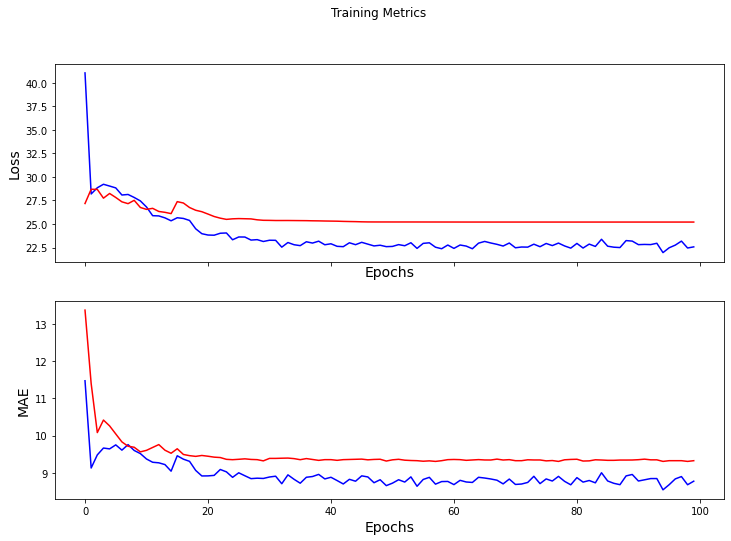

In [ ]:
plot_history(history)

**TESTING**

In [ ]:
test_image = testData[90]
test_image = tf.constant(test_image, dtype = 'float32')
test_image = tf.expand_dims(test_image, axis = 0)
prediction = model(test_image)

In [ ]:
prediction

<tf.Tensor: shape=(1, 70), dtype=float32, numpy=
array([[6.04403168e-02, 2.18289513e-02, 1.38765097e-01, 4.02215980e-02,
        5.28460145e-02, 1.65729061e-01, 1.54233212e-02, 9.44667310e-02,
        4.79953513e-02, 1.89156376e-03, 3.11193354e-02, 2.45790444e-02,
        1.38156582e-02, 2.24238448e-02, 3.86009645e-03, 3.89616899e-02,
        3.88677828e-02, 2.76776291e-02, 5.97310662e-02, 1.97438635e-02,
        2.21182480e-02, 2.60284822e-03, 1.99642871e-03, 6.15390064e-03,
        3.68672051e-03, 2.72324006e-03, 3.68177425e-03, 3.16851190e-03,
        7.89037161e-03, 6.37068995e-04, 3.66192614e-03, 7.25908962e-04,
        1.57867186e-03, 1.08273898e-03, 6.04753965e-04, 8.36935593e-04,
        1.05375948e-03, 2.63501570e-04, 4.34990274e-03, 7.52921624e-04,
        4.11275600e-04, 9.14780714e-04, 1.60146374e-04, 9.10633898e-05,
        1.73661436e-04, 2.10984866e-03, 4.48990380e-04, 3.46058339e-04,
        1.17394270e-03, 5.75804675e-04, 5.94685262e-04, 1.80096555e-04,
        5.33559

In [ ]:
prediction = tf.argmax(prediction, axis = 1, output_type=tf.int32)
prediction

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>

In [ ]:
age_pred = int(prediction.numpy())
print('Prediction', age_pred)

Prediction 5


In [ ]:
age_true = int(testLabels[90])
print('Ground true', age_true)

Ground true 13


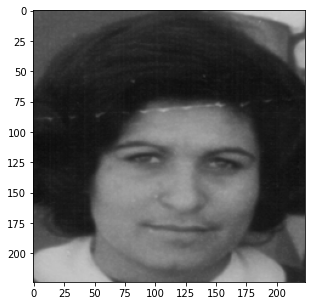

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(testData[90])
plt.show()

**LET'S LOAD SOME IMAGES AND TEST**

*Note that because data was trained on white people dataset so the prediction may not obtain a good result on none-white people*

In [ ]:
import numpy as np
import matplotlib as mp
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/drive/My Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET/' + fn
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x_tensor = tf.constant(x, dtype = 'float32')
  x_tensor = tf.expand_dims(x_tensor, axis = 0)
  probs = model(x_tensor, training = False)
  prediction = tf.argmax(probs, axis = 1, output_type=tf.int32)

  age_pred = int(prediction.numpy())
  mp.pyplot.figure(figsize = (5,5))
  mp.pyplot.imshow(img)
  mp.pyplot.axis('Off')
  mp.pyplot.show()
  print('Age: {}'.format(age_pred))

TypeError: ignored